Rows after merge: 119
Rows after assigning continents: 87
Continents in data: Continent
Africa           46
Americas         19
Asia              7
Europe            7
Oceania           7
North America     1
Name: count, dtype: int64


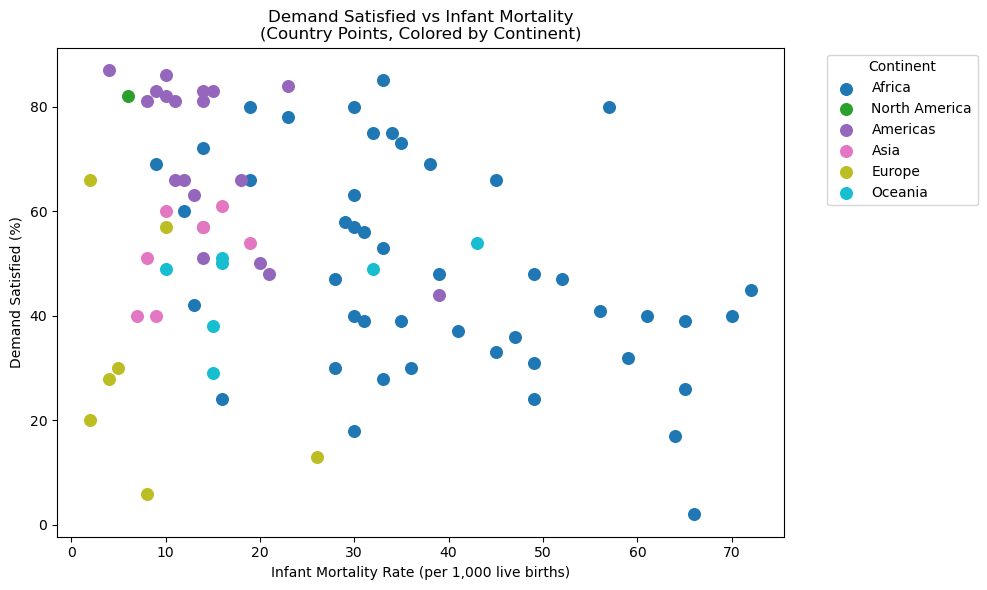


Correlation by continent:
Africa: r = -0.435
North America: r = nan
Americas: r = -0.615
Asia: r = 0.603
Europe: r = -0.357
Oceania: r = 0.443

FINAL DATAFRAME USED FOR PLOTS:

                      Country  DemandSatisfied  InfantMortality  \
3                     Algeria             66.0             19.0   
4                       Egypt             80.0             19.0   
5                       Libya             24.0             16.0   
6                     Morocco             72.0             14.0   
7                       Sudan             30.0             36.0   
8                     Tunisia             69.0              9.0   
11                      Benin             33.0             45.0   
12               Burkina Faso             57.0             30.0   
14              Cote d'Ivoire             47.0             52.0   
15                     Gambia             40.0             30.0   
16                      Ghana             47.0             28.0   
17                

/opt/anaconda3/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2991: RuntimeWarning:

Degrees of freedom <= 0 for slice

/opt/anaconda3/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2848: RuntimeWarning:

divide by zero encountered in divide

/opt/anaconda3/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2848: RuntimeWarning:

invalid value encountered in multiply



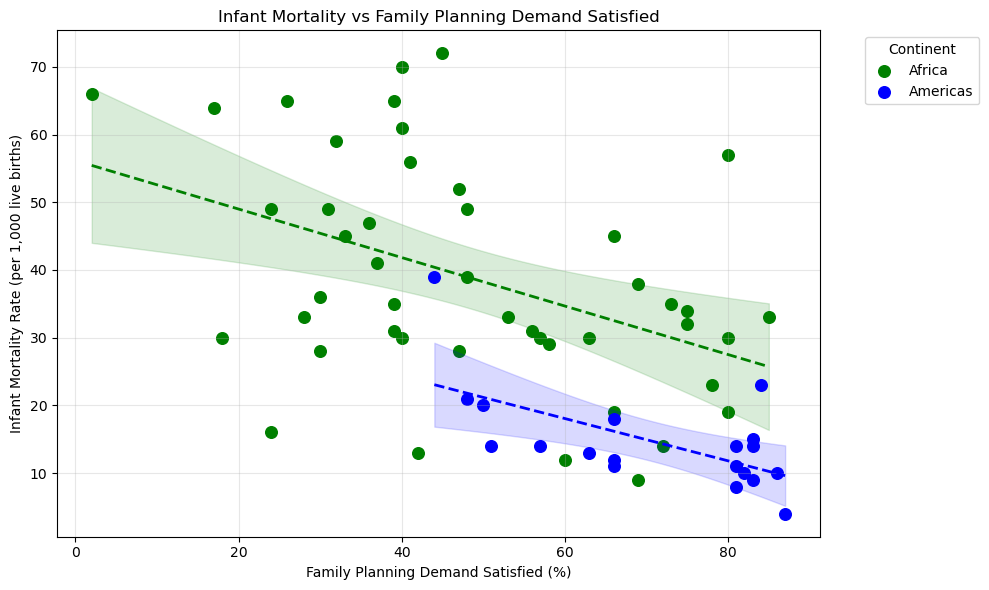

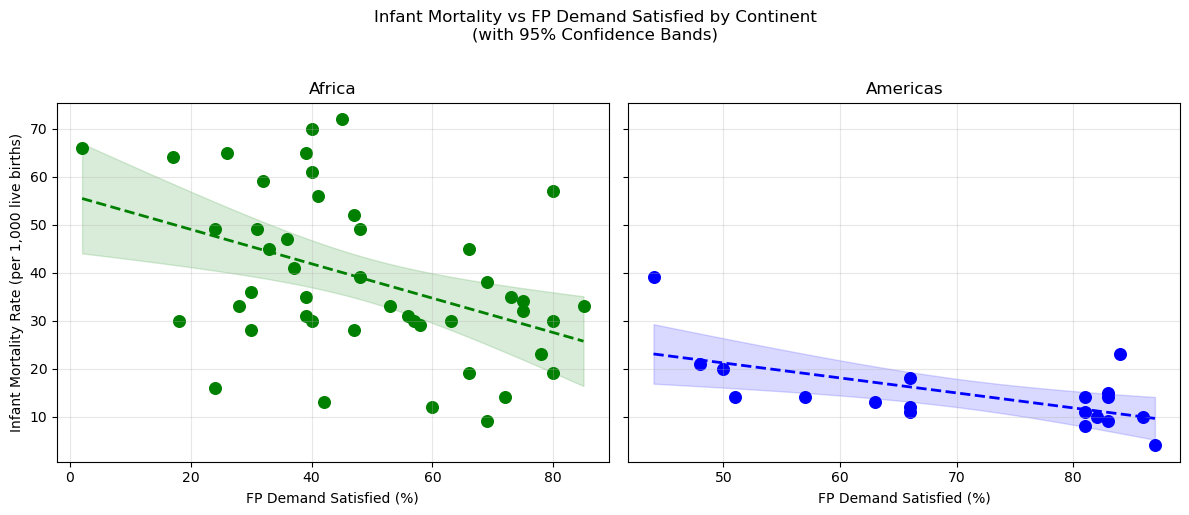


Correlation by continent (Africa & Americas):
Africa: r = -0.435
Americas: r = -0.615


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import plotly.graph_objects as go


# ---------------------------------------------------------
# 1. FILE PATHS
# ---------------------------------------------------------
demand_path = r"/Users/lilliankilduff/Downloads/110_Project/demand.csv"
imr_path    = r"/Users/lilliankilduff/Downloads/110_Project/IMR.csv"

# ---------------------------------------------------------
# 2. LOAD CSVs
# ---------------------------------------------------------
demand = pd.read_csv(demand_path)
imr    = pd.read_csv(imr_path)

# Clean column names
demand.columns = demand.columns.str.strip()
imr.columns    = imr.columns.str.strip()

# Rename for consistency
demand = demand.rename(columns={
    "Geography": "Country",
    "Demand Satisfied by Modern Methods Among Married Women": "DemandSatisfied"
})
imr = imr.rename(columns={
    "Geography": "Country",
    "Infant Mortality Rate": "InfantMortality"
})

# ---------------------------------------------------------
# 3. CLEAN TEXT FIELDS
# ---------------------------------------------------------
def clean_name(series):
    return (
        series.astype("string")
              .str.replace(r"[\u00A0\u200B]", "", regex=True)  # invisible spaces
              .str.replace(r"\s+", " ", regex=True)            # collapse multiple spaces
              .str.strip()
    )

demand["Country"] = clean_name(demand["Country"])
imr["Country"]    = clean_name(imr["Country"])

# ---------------------------------------------------------
# 4. BUILD Region FOR EACH COUNTRY FROM demand.csv
#    (region rows are ALL-CAPS: NORTHERN AFRICA, CARIBBEAN, etc.)
# ---------------------------------------------------------
region_by_country = {}
current_region = None

for name in demand["Country"]:
    if pd.isna(name):
        continue
    if name.isupper():          # REGION header row
        current_region = name
    else:                       # COUNTRY row
        if current_region is not None:
            region_by_country[name] = current_region

# ---------------------------------------------------------
# 5. CONVERT NUMERIC COLUMNS
# ---------------------------------------------------------
demand["DemandSatisfied"] = pd.to_numeric(demand["DemandSatisfied"], errors="coerce")
imr["InfantMortality"]    = pd.to_numeric(imr["InfantMortality"], errors="coerce")

# ---------------------------------------------------------
# 6. MERGE FILES AND KEEP RELEVANT COLUMNS
# ---------------------------------------------------------
df = demand[["Country", "DemandSatisfied"]].merge(
    imr[["Country", "InfantMortality"]],
    on="Country",
    how="inner"
)

df = df.dropna(subset=["DemandSatisfied", "InfantMortality"])

print("Rows after merge:", len(df))

# ---------------------------------------------------------
# 7. MAP Region -> Continent, THEN Country -> Region -> Continent
# ---------------------------------------------------------
region_to_continent = {
    # Africa
    "AFRICA": "Africa",
    "NORTHERN AFRICA": "Africa",
    "WESTERN AFRICA": "Africa",
    "EASTERN AFRICA": "Africa",
    "MIDDLE AFRICA": "Africa",
    "SOUTHERN AFRICA": "Africa",

    # Americas (you can split further if you like)
    "NORTHERN AMERICA": "North America",
    "LATIN AMERICA AND THE CARIBBEAN": "Americas",
    "CENTRAL AMERICA": "Americas",
    "CARIBBEAN": "Americas",
    "SOUTH AMERICA": "Americas",

    # Asia
    "ASIA": "Asia",
    "WESTERN ASIA": "Asia",
    "SOUTH-CENTRAL ASIA": "Asia",
    "SOUTH-EASTERN ASIA": "Asia",
    "EASTERN ASIA": "Asia",

    # Europe
    "EUROPE": "Europe",
    "NORTHERN EUROPE": "Europe",
    "WESTERN EUROPE": "Europe",
    "EASTERN EUROPE": "Europe",
    "SOUTHERN EUROPE": "Europe",

    # Oceania
    "OCEANIA": "Oceania"
}

# Add Region per country, then Continent per region
df["Region"] = df["Country"].map(region_by_country)
df["Continent"] = df["Region"].map(region_to_continent)

# Drop rows where we *still* don't know the continent
df = df.dropna(subset=["Continent"]).copy()

print("Rows after assigning continents:", len(df))
print("Continents in data:", df["Continent"].value_counts())

# ---------------------------------------------------------
# 8. SCATTER PLOT COLORED BY CONTINENT (STATIC)
# ---------------------------------------------------------
plt.figure(figsize=(10, 6))

continents = df["Continent"].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(continents)))

for cont, color in zip(continents, colors):
    sub = df[df["Continent"] == cont]
    plt.scatter(
        sub["InfantMortality"],
        sub["DemandSatisfied"],
        label=cont,
        s=70,
        color=color
    )

plt.xlabel("Infant Mortality Rate (per 1,000 live births)")
plt.ylabel("Demand Satisfied (%)")
plt.title("Demand Satisfied vs Infant Mortality\n(Country Points, Colored by Continent)")
plt.legend(title="Continent", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 9. CORRELATION BY CONTINENT
# ---------------------------------------------------------
print("\nCorrelation by continent:")
for cont in continents:
    sub = df[df["Continent"] == cont]
    r = sub["InfantMortality"].corr(sub["DemandSatisfied"])
    print(f"{cont}: r = {r:.3f}")

# ---------------------------------------------------------
# EXTRA: Focus only on Africa and Americas (Europe removed)
# ---------------------------------------------------------

focus_continents = ["Africa", "Americas"]

df_focus = df[df["Continent"].isin(focus_continents)].copy()

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
print("\nFINAL DATAFRAME USED FOR PLOTS:\n")
print(df_focus)

print("\nRows in focus continents:", len(df_focus))
print("Continents in focus plot:", df_focus["Continent"].value_counts())

# Custom colors
continent_colors = {
    "Africa": "green",
    "Americas": "blue"
}

# ---------------------------------------------------------
# Helper: fit regression + 95% CI
# ---------------------------------------------------------
def regression_with_ci(x, y, x_grid):
    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()
    Xg = sm.add_constant(x_grid)
    pred = model.get_prediction(Xg)
    mean = pred.predicted_mean
    ci = pred.conf_int(alpha=0.05)  # 95% CI
    lower = ci[:, 0]
    upper = ci[:, 1]
    return mean, lower, upper

# ---------------------------------------------------------
# C1. COMBINED SCATTER PLOT (Africa = green, Americas = blue) - STATIC
# ---------------------------------------------------------
plt.figure(figsize=(10, 6))

for cont in focus_continents:
    color = continent_colors[cont]
    sub = df_focus[df_focus["Continent"] == cont]

    x = sub["DemandSatisfied"].values
    y = sub["InfantMortality"].values

    # Scatter (X = DemandSatisfied, Y = IMR)
    plt.scatter(x, y, label=cont, s=70, color=color)

    # Regression line + 95% CI band
    if len(sub) >= 3:
        x_grid = np.linspace(x.min(), x.max(), 100)
        mean, lower, upper = regression_with_ci(x, y, x_grid)
        plt.plot(x_grid, mean, linestyle="--", color=color, linewidth=2)
        plt.fill_between(x_grid, lower, upper, color=color, alpha=0.15)

plt.grid(True, alpha=0.3)
plt.xlabel("Family Planning Demand Satisfied (%)")
plt.ylabel("Infant Mortality Rate (per 1,000 live births)")
plt.title("Infant Mortality vs Family Planning Demand Satisfied")
plt.legend(title="Continent", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# C2. TWO SUBPLOTS (Africa & Americas) WITH CI - STATIC
# ---------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

for ax, cont in zip(axes, focus_continents):
    color = continent_colors[cont]
    sub = df_focus[df_focus["Continent"] == cont]

    x = sub["DemandSatisfied"].values
    y = sub["InfantMortality"].values

    # Scatter
    ax.scatter(x, y, s=70, color=color)

    # Regression line + 95% CI
    if len(sub) >= 3:
        x_grid = np.linspace(x.min(), x.max(), 100)
        mean, lower, upper = regression_with_ci(x, y, x_grid)
        ax.plot(x_grid, mean, linestyle="--", color=color, linewidth=2)
        ax.fill_between(x_grid, lower, upper, color=color, alpha=0.15)

    ax.grid(True, alpha=0.3)
    ax.set_title(cont)
    ax.set_xlabel("FP Demand Satisfied (%)")

axes[0].set_ylabel("Infant Mortality Rate (per 1,000 live births)")
fig.suptitle("Infant Mortality vs FP Demand Satisfied by Continent\n(with 95% Confidence Bands)", y=1.02)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# C3. Correlation ONLY for Africa & Americas
# ---------------------------------------------------------
print("\nCorrelation by continent (Africa & Americas):")
for cont in focus_continents:
    sub = df_focus[df_focus["Continent"] == cont]
    r = sub["DemandSatisfied"].corr(sub["InfantMortality"])
    print(f"{cont}: r = {r:.3f}")

# ---------------------------------------------------------
# C4. INTERACTIVE PLOTLY PLOT WITH REGRESSION + 95% CI
# ---------------------------------------------------------

continent_colors_plotly = {
    "Africa": "green",
    "Americas": "blue"
}

fig = go.Figure()

for cont in focus_continents:
    sub = df_focus[df_focus["Continent"] == cont].copy()
    x = sub["DemandSatisfied"].values
    y = sub["InfantMortality"].values
    color = continent_colors_plotly[cont]

    # Scatter points with country hovertext
    fig.add_trace(go.Scatter(
        x=x,
        y=y,
        mode="markers",
        name=f"{cont} countries",
        marker=dict(color=color, size=8),
        hovertext=sub["Country"],
        hovertemplate=(
            "<b>%{hovertext}</b><br>" +
            "FP demand satisfied: %{x:.1f}%<br>" +
            "Infant mortality: %{y:.1f} per 1,000<br>" +
            f"Continent: {cont}<extra></extra>"
        )
    ))

    # Regression line + CI band (hover disabled so dots keep priority)
    if len(sub) >= 3:
        x_grid = np.linspace(x.min(), x.max(), 100)
        mean, lower, upper = regression_with_ci(x, y, x_grid)

        # Regression line
        fig.add_trace(go.Scatter(
            x=x_grid,
            y=mean,
            mode="lines",
            name=f"{cont} trend line",
            line=dict(color=color, dash="dash"),
            hoverinfo="skip"   # don't show hover for the line
        ))

        # Confidence interval band
        fig.add_trace(go.Scatter(
            x=np.concatenate([x_grid, x_grid[::-1]]),
            y=np.concatenate([upper, lower[::-1]]),
            fill="toself",
            fillcolor=color,
            line=dict(width=0),
            opacity=0.15,
            name=f"{cont} 95% CI",
            hoverinfo="skip"   # don't show hover for the band
        ))

fig.update_layout(
    title="Infant Mortality vs FP Demand Satisfied",
    xaxis_title="Family Planning Demand Satisfied (%)",
    yaxis_title="Infant Mortality Rate (per 1,000 live births)",
    template="simple_white",
    hovermode="closest"
)

# Save interactive plot as HTML and open in browser
fig.write_html("interactive_fp_imr_with_ci.html", auto_open=True)
